In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [2]:
!kaggle competitions download -c severstal-steel-defect-detection

100% 1.56G/1.57G [00:16<00:00, 165MB/s]
100% 1.57G/1.57G [00:16<00:00, 102MB/s]


In [3]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [4]:
# Load CSV file for labels
data = pd.read_csv("/content/train.csv")

In [5]:
data.shape

(7095, 3)

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

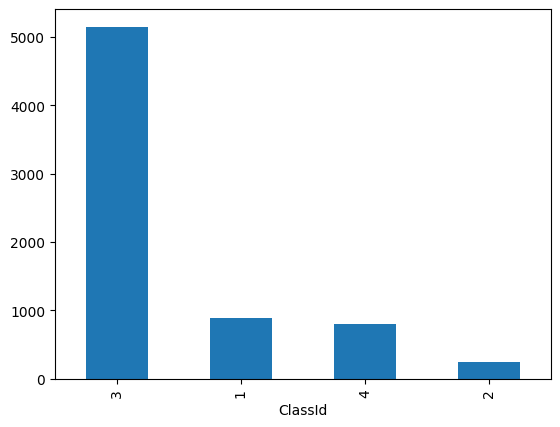

In [6]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

In [7]:
# After loading CSV file for labels
class_counts = data["ClassId"].value_counts()
total_count = class_counts.sum()
num_classes = len(class_counts)
weight_dictionary = {class_id: total_count / count for class_id, count in class_counts.items()}

# Convert class IDs to indices starting from 0
class_indices = range(num_classes)
class_weight_dict = {index: weight_dictionary.get(class_id, 1.0) for class_id, index in zip(class_counts.index, class_indices)}
print(class_weight_dict)


{0: 1.3776699029126214, 1: 7.909698996655519, 2: 8.857677902621722, 3: 28.724696356275302}


In [8]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("/content/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|██████████| 7095/7095 [00:45<00:00, 154.77it/s]


In [9]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)



x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


In [11]:
from keras.applications import vgg16

In [12]:
img_rows, img_cols = 120, 120

In [13]:
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))



In [14]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False


In [15]:
# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)



0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [18]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [19]:
from keras.callbacks import EarlyStopping

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
# Modify the model training phase to pass class weights
history = model.fit(X_train, y_train,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    initial_epoch=0,
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/15
178/178 [==============================] - 19s 72ms/step - loss: 6.9595 - accuracy: 0.6705 - val_loss: 0.8960 - val_accuracy: 0.6934
Epoch 2/15
178/178 [==============================] - 10s 54ms/step - loss: 5.3496 - accuracy: 0.7252 - val_loss: 0.7739 - val_accuracy: 0.7576
Epoch 3/15
178/178 [==============================] - 9s 51ms/step - loss: 5.1536 - accuracy: 0.7223 - val_loss: 0.7314 - val_accuracy: 0.7378
Epoch 4/15
178/178 [==============================] - 9s 49ms/step - loss: 4.7301 - accuracy: 0.7408 - val_loss: 0.7213 - val_accuracy: 0.7569
Epoch 5/15
178/178 [==============================] - 10s 56ms/step - loss: 4.6256 - accuracy: 0.7340 - val_loss: 0.7121 - val_accuracy: 0.7632
Epoch 6/15
178/178 [==============================] - 10s 54ms/step - loss: 4.3985 - accuracy: 0.7467 - val_loss: 0.7435 - val_accuracy: 0.7153
Epoch 7/15
178/178 [==============================] - 10s 56ms/step - loss: 4.3826 - accuracy: 0.7454 - val_loss: 0.7366 - val_accuracy: 0

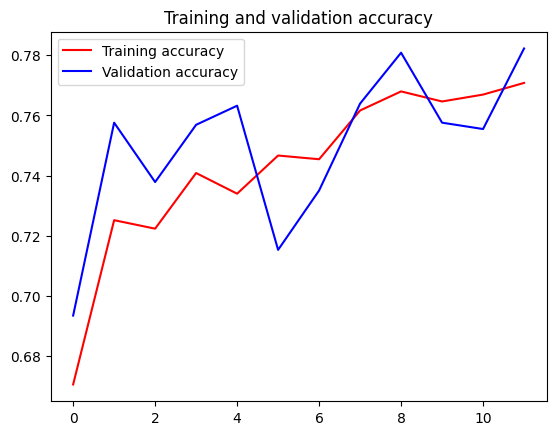

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [23]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test, axis=1)

45/45 [==============================] - 2s 38ms/step


In [24]:
from sklearn.metrics import classification_report

classification_report_ = classification_report(y_test, y_prediction)
print("Classification Report:")
print(classification_report_)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.15      0.25       179
           1       0.54      0.88      0.67        50
           2       0.85      0.88      0.86      1030
           3       0.55      0.82      0.66       160

    accuracy                           0.78      1419
   macro avg       0.72      0.68      0.61      1419
weighted avg       0.81      0.78      0.76      1419



In [25]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_prediction)
print("Confusion Matrix:")
print(confusion_mtx)


Confusion Matrix:
[[ 26  15 131   7]
 [  0  44   6   0]
 [  2  21 906 101]
 [  0   1  27 132]]


In [26]:
# Save the trained model
model.save("Vgg16_weight_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
